In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as ex
import plotly.graph_objs as go
import plotly.figure_factory as ff
from plotly.subplots import make_subplots
import plotly.offline as pyo

In [2]:
train = pd.read_json("train.json")
test = pd.read_json("test.json")
test.head()

,id,ingredients
0,10210,"[barbecue sauce, yellow onion, prepared pizza ..."
1,2310,"[olive oil, stewed tomatoes, hot sauce, chicke..."
2,33213,"[chopped bell pepper, cilantro leaves, white o..."
3,16902,"[tomatoes, purple onion, cumin seed, red lenti..."
4,9056,"[chile powder, lime, blackpepper, ground clove..."


In [3]:
# onehot encoder for ingredients
from sklearn.preprocessing import MultiLabelBinarizer

mlb = MultiLabelBinarizer()
expandedLabelData_train = mlb.fit_transform(train["ingredients"])
labelClasses = mlb.classes_
expandedLabelData_test = mlb.fit_transform(test["ingredients"])
labelClasses_2 = mlb.classes_

expandedLabels_train = pd.DataFrame(expandedLabelData_train, columns=labelClasses)
expandedLabels_test = pd.DataFrame(expandedLabelData_test, columns=labelClasses_2)
print(expandedLabels_train)
print()
print(expandedLabels_test)

       (    oz.) tomato sauce  (   oz.) tomato paste  \
0                           0                      0   
1                           0                      0   
2                           0                      0   
3                           0                      0   
4                           0                      0   
...                       ...                    ...   
29769                       0                      0   
29770                       0                      0   
29771                       0                      0   
29772                       0                      0   
29773                       0                      0   

       (10 oz.) frozen chopped spinach  \
0                                    0   
1                                    0   
2                                    0   
3                                    0   
4                                    0   
...                                ...   
29769                            

In [4]:
# shuffle data
from numpy import nan

def shuffle(df_origin): 
    df = df_origin.sample(frac=1,random_state=113)#,random_state=113
    df2= df.reset_index(drop=True)
    return df2

df = pd.DataFrame(train)
df = pd.concat([df,expandedLabels_train], axis = 1)
df_shuffle_train = shuffle(df)
print(df_shuffle_train)

df = pd.DataFrame(test)
df = pd.concat([df,expandedLabels_test], axis = 1)
df_shuffle_test = shuffle(df)
print(df_shuffle_test)

df_mix = pd.concat([df_shuffle_train, df_shuffle_test])
df_mix= df_mix.replace(nan, 0)
print(df_mix)


          id   cuisine                                        ingredients  \
0      45758   italian  [bread crumbs, ricotta cheese, fresh parsley, ...   
1       2065     greek  [large eggs, salt, dried oregano, plain yogurt...   
2        968    korean  [light brown sugar, dijon mustard, paprika, Go...   
3      30592   mexican  [shredded cheddar cheese, red bell pepper, gre...   
4      44223    indian  [jasmine rice, unsalted butter, grapeseed oil,...   
...      ...       ...                                                ...   
29769   3997    french  [cherries, all-purpose flour, sugar, refrigera...   
29770   4245  japanese  [avocado, crabmeat, sushi rice, nori, soy sauc...   
29771  36461   italian  [parmigiano reggiano cheese, crusty bread, par...   
29772  44094  japanese  [boneless chicken breast, salt, soy sauce, mus...   
29773  14160   italian  [tomato sauce, bacon, onions, butter, bow-tie ...   

       (    oz.) tomato sauce  (   oz.) tomato paste  \
0                  

In [5]:
#PCA for lower down dimensionality
from sklearn.decomposition import PCA
N_COMPONENTS = 2048
pca = PCA(N_COMPONENTS)
pca.fit(df_mix[df_mix.columns[3:]])
df_mix_pca = pd.DataFrame(pca.transform(df_mix[df_mix.columns[3:]]))
df_mix_pca.head()

print(df_mix_pca)

           0         1         2         3         4         5         6     \
0      0.510982  0.088518 -0.672753 -0.158376  0.414495  0.268091 -0.137284   
1      0.274644  0.375971 -0.176782  0.065640  0.075968 -0.475731  0.255792   
2     -0.307932  0.051774  0.877637 -0.059074  0.309773  0.580567 -0.154620   
3     -0.559968 -0.159165 -0.164936 -0.188891 -0.156836 -0.321363 -0.230882   
4     -0.312332 -0.461955  0.375438 -0.446578  0.049873 -0.273498  0.153156   
...         ...       ...       ...       ...       ...       ...       ...   
39769 -0.794928  0.016763  0.615479  0.982461  0.703543  0.028578  0.929613   
39770  0.417789  1.046598  0.052702  0.086276 -0.335018  0.499626 -0.514245   
39771  0.446145  0.307237 -0.438216  0.144716  0.617088  0.304539  0.038731   
39772 -0.515761 -0.015798  0.253565  0.321376 -0.101324  0.153866 -0.802781   
39773 -0.600770 -0.027741 -0.127006 -0.146289 -0.086928 -0.206495 -0.233840   

           7         8         9     ...      2038 

In [6]:
#transform cuisine
from sklearn import preprocessing

le = preprocessing.LabelEncoder()
le.fit(df_shuffle_train.cuisine)

df_shuffle_train.cuisine = le.transform(df_shuffle_train.cuisine)
print(df_shuffle_train.cuisine)
print(le.classes_)

0         9
1         6
2        12
3        13
4         7
         ..
29769     5
29770    11
29771     9
29772    11
29773     9
Name: cuisine, Length: 29774, dtype: int32
['brazilian' 'british' 'cajun_creole' 'chinese' 'filipino' 'french'
 'greek' 'indian' 'irish' 'italian' 'jamaican' 'japanese' 'korean'
 'mexican' 'moroccan' 'russian' 'southern_us' 'spanish' 'thai'
 'vietnamese']


In [64]:
# train_test_split
from sklearn.model_selection import train_test_split

df_shuffle_train_pca = df_mix_pca.iloc[:29774, :]
df_shuffle_test_pca = df_mix_pca.iloc[29774:39774, :]
print(df_shuffle_train_pca)
print(df_shuffle_test_pca)

train_x,test_x,train_y,test_y = train_test_split(df_shuffle_train_pca, df_shuffle_train.cuisine, random_state=42, test_size=0.10)
print(len(train_x))
print()
print(len(test_x))
"""

df_shuffle_train_pca = df_mix.iloc[:29774, :].drop(['ingredients', 'id', 'cuisine'], axis=1)
df_shuffle_test_pca = df_mix.iloc[29774:39774, :].drop(['ingredients', 'id', 'cuisine'],axis=1)
print(df_shuffle_train_pca)
print(df_shuffle_test_pca)

train_x,test_x,train_y,test_y = train_test_split(df_shuffle_train_pca, df_shuffle_train.cuisine, random_state=42, test_size=0.30)
print(len(train_x))
print()
print(len(test_x))"""

           0         1         2         3         4         5         6     \
0      0.510982  0.088518 -0.672753 -0.158376  0.414495  0.268091 -0.137284   
1      0.274644  0.375971 -0.176782  0.065640  0.075968 -0.475731  0.255792   
2     -0.307932  0.051774  0.877637 -0.059074  0.309773  0.580567 -0.154620   
3     -0.559968 -0.159165 -0.164936 -0.188891 -0.156836 -0.321363 -0.230882   
4     -0.312332 -0.461955  0.375438 -0.446578  0.049873 -0.273498  0.153156   
...         ...       ...       ...       ...       ...       ...       ...   
29769 -0.665545  0.920214 -0.063421 -0.161680 -0.131944  0.567556  0.401429   
29770 -0.671867 -0.091928  0.172037 -0.045338  0.193025 -0.299653 -0.056879   
29771 -0.565840  0.085216 -0.128558 -0.272880 -0.135283 -0.122996 -0.250916   
29772  0.495289  0.003097  0.264597  0.721648 -0.450540 -0.299760  0.982927   
29773  0.664425  0.181223 -0.013030 -0.299707 -0.744751 -0.018418 -0.042312   

           7         8         9     ...      2038 

"\n\ndf_shuffle_train_pca = df_mix.iloc[:29774, :].drop(['ingredients', 'id', 'cuisine'], axis=1)\ndf_shuffle_test_pca = df_mix.iloc[29774:39774, :].drop(['ingredients', 'id', 'cuisine'],axis=1)\nprint(df_shuffle_train_pca)\nprint(df_shuffle_test_pca)\n\ntrain_x,test_x,train_y,test_y = train_test_split(df_shuffle_train_pca, df_shuffle_train.cuisine, random_state=42, test_size=0.30)\nprint(len(train_x))\nprint()\nprint(len(test_x))"

In [68]:
# validation--> SVM
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

svm_clf_lin = SVC(random_state=42,kernel='linear', C=1.5)
svm_clf_poly = SVC(random_state=42,kernel='poly', C=1.5)
svm_clf_rbf = SVC(random_state=42,kernel='rbf', C=1.5)
svm_clf_sigmoid = SVC(random_state=42,kernel='sigmoid', C=1.5)

svm_clf_lin = svm_clf_lin.fit(train_x,train_y)
#print('1')
svm_clf_poly = svm_clf_poly.fit(train_x,train_y)
#print('2')
svm_clf_rbf = svm_clf_rbf.fit(df_shuffle_train_pca,df_shuffle_train.cuisine)
#print('3')
svm_clf_sigmoid = svm_clf_sigmoid.fit(train_x,train_y)

In [62]:
pred = []
pred.append(svm_clf_lin.predict(test_x))
print('1')
pred.append(svm_clf_poly.predict(test_x))
print('2')
pred.append(svm_clf_rbf.predict(test_x))
print('3')
pred.append(svm_clf_sigmoid.predict(test_x))

"print('1')\npred.append(svm_clf_poly.predict(test_x))\nprint('2')\npred.append(svm_clf_rbf.predict(test_x))\nprint('3')\npred.append(svm_clf_sigmoid.predict(test_x))"

0
recall:  0.7312213142281428
precision:  0.7689262705496981
accuracy:  0.7312213142281428



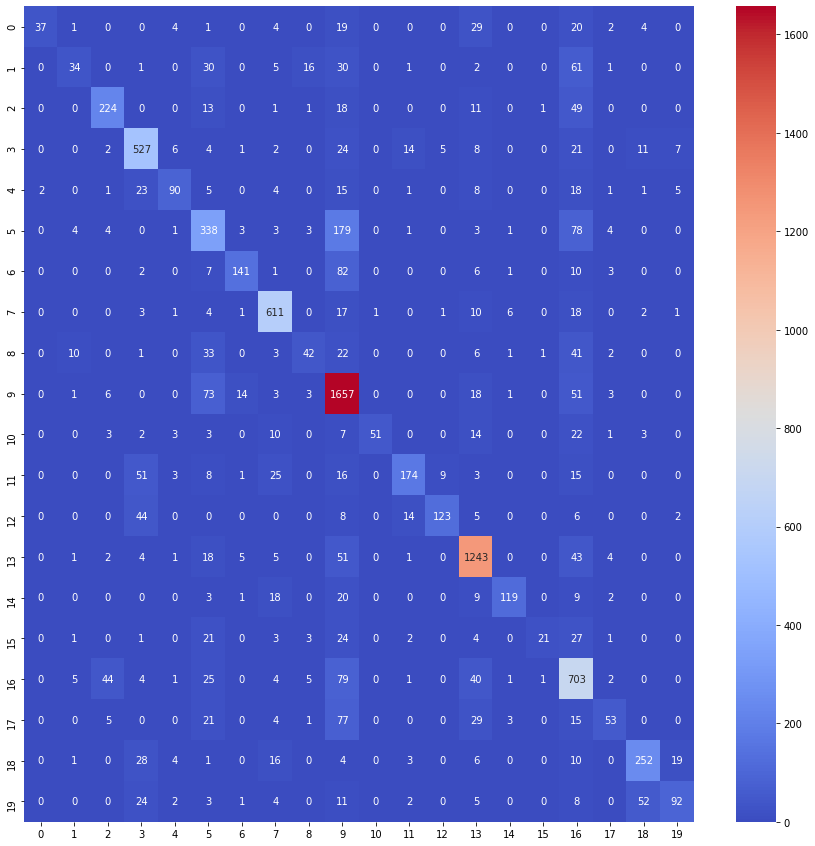

In [63]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import accuracy_score

for i in range(len(pred)):
    print(i)
    fig, ax = plt.subplots(figsize=(15,15))
    ax = sns.heatmap(confusion_matrix(test_y, pred[i]),annot=True,cmap='coolwarm',fmt='d')
    print("recall: ", recall_score(test_y, pred[i], average='micro'))
    print("precision: ", precision_score(test_y, pred[i], average='macro'))
    print("accuracy: ", accuracy_score(test_y, pred[i]))
    print()
    plt.savefig(str(i))
    

In [69]:
sub = svm_clf_rbf.predict(df_shuffle_test_pca)

In [70]:
submit = le.inverse_transform(pd.Series(sub))
submit = pd.concat([pd.Series(df_shuffle_test.id, name='Id'), pd.Series(submit, name='Category')], axis=1)
print(submit.to_csv(index=False))
submit.to_csv("submission.csv", index = False)


Id,Category
9356,italian
31575,southern_us
3603,southern_us
5099,southern_us
13393,mexican
33105,vietnamese
18363,italian
10466,southern_us
25480,italian
4444,southern_us
11715,mexican
5766,moroccan
39856,filipino
6548,southern_us
23756,french
7334,southern_us
42644,chinese
47978,mexican
10103,italian
30801,mexican
6729,irish
42628,mexican
20048,cajun_creole
8633,italian
20666,mexican
30385,southern_us
27628,italian
24392,southern_us
37299,mexican
31384,japanese
35328,southern_us
40134,vietnamese
3808,mexican
10098,southern_us
31743,southern_us
30460,russian
13492,chinese
10293,chinese
48993,mexican
26671,italian
13373,southern_us
18795,italian
17332,italian
42217,southern_us
18034,southern_us
39009,chinese
44699,french
11109,italian
614,mexican
2930,southern_us
35566,italian
13585,thai
1528,mexican
15593,thai
32751,mexican
40295,chinese
478,cajun_creole
23240,mexican
10355,french
31805,indian
5047,southern_us
27299,french
28988,mexican
48956,southern_us
15679,mexican
32291,mexican
340

In [71]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

train_x = train_x.astype("float32")
train_y = train_y.astype("float32")
test_x = test_x.astype("float32")
test_y = test_y.astype("float32")
d = df_shuffle_train_pca.astype("float32")
de = df_shuffle_train.cuisine.astype("float32")

# Reserve 8933 samples for validation
val_x = train_x[-8933:]
val_y = train_y[-8933:]
train_x = train_x[:-8933]
train_y = train_y[:-8933]
val_d = d[-10000:]
val_de = de[-10000:]
d = d[:-10000]
de = de[:-10000]



29774
29774
17863
17863
           0         1         2         3         4         5         6     \
62     0.706901 -0.215723 -0.041465 -0.087319 -0.470624 -0.260209  0.269399   
0      0.510982  0.088518 -0.672753 -0.158376  0.414495  0.268091 -0.137284   
26692 -0.662264  0.921904 -0.074150 -0.352148 -0.265992  0.520601  0.125049   
3462  -0.696342 -0.005091  0.061752  0.018721  0.121928  0.000462  0.302510   
23390  0.247442  0.894504 -0.159119 -0.434057 -0.216032 -0.092822 -0.227729   
...         ...       ...       ...       ...       ...       ...       ...   
23772  0.185370  0.298074 -0.258357 -0.004121  0.111122 -0.500555 -0.144098   
28600 -0.597693 -0.123942 -0.146295 -0.232487 -0.141197 -0.434871 -0.328926   
20905 -0.203502  0.038251  0.204143 -0.310703 -0.823634  0.235637  0.260298   
8249   0.429928  0.174281  0.400697  0.413314 -0.010789 -0.261259 -0.721386   
20868 -0.699684  0.089424  0.304377 -0.135476  0.197960 -0.142358  0.047092   

           7         8     

In [72]:
"""from sklearn.metrics import confusion_matrix
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dropout, Dense
from sklearn.metrics import accuracy_score
from talos.utils import lr_normalizer"""
model = Sequential()                
model.add(Dense(256,
                input_shape=(2048,),
                activation='relu'))
# model.add(Dense(64,
#                 activation='relu'))
model.add(Dense(20, activation='hard_sigmoid'))
model.compile(
    optimizer=tf.keras.optimizers.Nadam(lr=lr_normalizer(0.01, tf.keras.optimizers.Nadam)),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=[tf.keras.metrics.SparseCategoricalAccuracy()],
)
model.fit(
    d.values, de.values,
    batch_size=2,
    epochs=60,
    verbose=0,
    validation_data=(val_d, val_de)
)
"""            
y = model.predict(test_x.values)
pred = []
for j in range(len(y)):
    pred.append(np.argmax(y[j]))

print("recall: ", recall_score(test_y, pred, average='micro'))
print("precision: ", precision_score(test_y, pred, average='macro'))
print("accuracy: ", accuracy_score(test_y, pred))
ax = sns.heatmap(confusion_matrix(test_y, pred),annot=True,cmap='coolwarm',fmt='d')
print()
plt.savefig('EMG.jpg') 
"""


'            \ny = model.predict(test_x.values)\npred = []\nfor j in range(len(y)):\n    pred.append(np.argmax(y[j]))\n\nprint("recall: ", recall_score(test_y, pred, average=\'micro\'))\nprint("precision: ", precision_score(test_y, pred, average=\'macro\'))\nprint("accuracy: ", accuracy_score(test_y, pred))\nax = sns.heatmap(confusion_matrix(test_y, pred),annot=True,cmap=\'coolwarm\',fmt=\'d\')\nprint()\nplt.savefig(\'EMG.jpg\') \n'

In [73]:
q = df_shuffle_test_pca.astype("float32")
y = model.predict(q)
pred = []
for j in range(len(y)):
    pred.append(np.argmax(y[j]))

print(pred)


[9, 16, 16, 16, 13, 18, 9, 2, 9, 16, 13, 14, 4, 2, 5, 16, 3, 10, 9, 13, 6, 13, 2, 9, 13, 7, 5, 16, 13, 11, 16, 4, 13, 16, 16, 15, 3, 3, 13, 9, 16, 9, 9, 16, 16, 3, 15, 9, 13, 16, 9, 18, 13, 18, 13, 3, 16, 13, 5, 7, 16, 5, 13, 16, 13, 16, 2, 15, 3, 3, 16, 10, 1, 9, 18, 13, 9, 9, 5, 7, 16, 3, 16, 5, 6, 6, 10, 9, 13, 13, 18, 6, 13, 7, 13, 12, 7, 9, 2, 1, 13, 7, 9, 17, 13, 11, 16, 13, 0, 12, 13, 17, 16, 13, 9, 3, 13, 16, 16, 5, 3, 7, 5, 9, 7, 6, 9, 9, 7, 2, 7, 9, 13, 7, 13, 16, 13, 13, 9, 13, 13, 19, 7, 13, 9, 14, 9, 9, 9, 2, 11, 7, 5, 3, 3, 7, 3, 9, 9, 0, 3, 13, 16, 9, 9, 3, 2, 5, 18, 3, 1, 3, 7, 16, 3, 13, 6, 3, 9, 7, 0, 16, 9, 3, 16, 9, 9, 9, 3, 3, 9, 13, 2, 9, 13, 13, 18, 2, 2, 3, 5, 9, 13, 9, 7, 9, 2, 16, 13, 16, 6, 16, 9, 11, 16, 13, 3, 9, 16, 2, 13, 13, 9, 2, 3, 18, 3, 13, 18, 16, 16, 13, 9, 9, 15, 3, 18, 7, 9, 17, 9, 5, 13, 9, 9, 9, 19, 11, 9, 9, 5, 2, 16, 9, 9, 16, 9, 3, 9, 16, 9, 9, 18, 9, 6, 16, 16, 1, 9, 16, 13, 5, 2, 9, 5, 16, 9, 13, 7, 3, 13, 3, 9, 16, 3, 5, 9, 18, 13, 2, 3, 

In [74]:
submit_nn = le.inverse_transform(pd.Series(pred))
submit_nn = pd.concat([pd.Series(df_shuffle_test.id, name='Id'), pd.Series(submit_nn, name='Category')], axis=1)
print(submit_nn)
submit_nn.to_csv("submission_nn.csv", index = False)

         Id     Category
0      9356      italian
1     31575  southern_us
2      3603  southern_us
3      5099  southern_us
4     13393      mexican
...     ...          ...
9995  24775      chinese
9996   7449  southern_us
9997  19211      mexican
9998   8966  southern_us
9999  29738         thai

[10000 rows x 2 columns]


In [28]:
# use talos for hyperparameters optimization
import talos
from talos.utils import lr_normalizer

In [35]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dropout, Dense

def cuisine_model(x_train, y_train, x_val, y_val, params):
    
    model = Sequential()                            
    model.add(Dense(params['first_neuron'],
                    input_shape=(2048,),
                    activation='relu'))
    
    model.add(Dense(128, activation='relu'))
    model.add(Dense(20, activation=param['last_activation']))
  
    model.compile(optimizer=params['optimizer'](lr=lr_normalizer(params['lr'], params['optimizer'])),
                  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                  metrics=[tf.keras.metrics.SparseCategoricalAccuracy()])

    out = model.fit(x_train, y_train,
                    epochs=params['epochs'],
                    batch_size=params['batch_size'],
                    verbose=0,
                    validation_data=(x_val, y_val)   )
    
    return out, model

In [36]:
# parameter tester
from tensorflow.keras.optimizers import Adadelta, Nadam, Adagrad
from tensorflow.keras.activations import softmax, hard_sigmoid
from tensorflow.keras.losses import categorical_crossentropy, logcosh
import tensorflow as tf
p = {'lr': [0.01, 0.05],
     'first_neuron':[480, 400],
     'epochs': [40],
     'batch_size': [2, 30],
     'optimizer': [Nadam],    
     'loss': ['categorical_crossentropy'],
     'last_activation': ['sigmoid', 'hard_sigmoid'],
     'weight_regulizer': [None]}

In [37]:
# scan
scan_object = talos.Scan(train_x.values,
                         train_y.values, 
                         params=p,
                         model=cuisine_model,
                         experiment_name='cuisine')





  0%|          | 0/4 [00:00<?, ?it/s]

UnboundLocalError: local variable 'logs' referenced before assignment

In [35]:
# accessing the results data frame
scan_object.data.head()

# accessing epoch entropy values for each round
scan_object.learning_entropy

# access the summary details
scan_object.details

experiment_name                 cuisine
random_method          uniform_mersenne
reduction_method                   None
reduction_interval                   50
reduction_window                     20
reduction_threshold                 0.2
reduction_metric                val_acc
complete_time            12/24/20/05:40
x_shape                   (11908, 2048)
y_shape                        (11908,)
dtype: object

In [37]:
# use Scan object as input
analyze_object = talos.Analyze(scan_object)

In [38]:
# access the dataframe with the results
analyze_object.data

,start,end,duration,round_epochs,loss,sparse_categorical_accuracy,val_loss,val_sparse_categorical_accuracy,batch_size,epochs,first_neuron,last_activation,loss,lr,optimizer,weight_regulizer
0,12/24/20-010657,12/24/20-013446,1669.719779,40,2.717376,0.309538,2.711629,0.320179,2,40,256,softmax,categorical_crossentropy,0.01,<class 'tensorflow.python.keras.optimizer_v2.n...,None
1,12/24/20-013447,12/24/20-020129,1602.056786,40,2.210795,0.791962,2.337826,0.677862,2,40,256,softmax,categorical_crossentropy,0.10,<class 'tensorflow.python.keras.optimizer_v2.n...,None
2,12/24/20-020130,12/24/20-022848,1638.465061,40,2.409985,0.639952,2.441540,0.604534,2,40,256,hard_sigmoid,categorical_crossentropy,0.01,<class 'tensorflow.python.keras.optimizer_v2.n...,None
3,12/24/20-022848,12/24/20-025556,1627.493490,40,2.206030,0.834913,2.379289,0.677302,2,40,256,hard_sigmoid,categorical_crossentropy,0.10,<class 'tensorflow.python.keras.optimizer_v2.n...,None
4,12/24/20-025556,12/24/20-033709,2473.102673,40,2.716820,0.307259,2.710614,0.318220,2,40,400,softmax,categorical_crossentropy,0.01,<class 'tensorflow.python.keras.optimizer_v2.n...,None
5,12/24/20-033709,12/24/20-041806,2457.328378,40,2.213444,0.812837,2.342608,0.691016,2,40,400,softmax,categorical_crossentropy,0.10,<class 'tensorflow.python.keras.optimizer_v2.n...,None
6,12/24/20-041807,12/24/20-045950,2502.910080,40,2.374402,0.676665,2.413375,0.627764,2,40,400,hard_sigmoid,categorical_crossentropy,0.01,<class 'tensorflow.python.keras.optimizer_v2.n...,None
7,12/24/20-045950,12/24/20-054055,2465.721149,40,2.206167,0.838392,2.382927,0.673384,2,40,400,hard_sigmoid,categorical_crossentropy,0.10,<class 'tensorflow.python.keras.optimizer_v2.n...,None


In [39]:
# get the highest result for any metric
analyze_object.high('val_sparse_categorical_accuracy')

0.6910159587860107

In [149]:
# get the round with the best result
analyze_object.rounds2high('val_sparse_categorical_accuracy')

2

In [96]:
# get the best paramaters
analyze_object.best_params('val_sparse_categorical_accuracy', ['acc', 'loss', 'val_loss'])

array([[2,
        <class 'tensorflow.python.keras.optimizer_v2.adadelta.Adadelta'>,
        '12/21/20-220923', '12/21/20-221123', 40, 128, 40,
        0.9419047832489014, 'softmax', 0.4, None, 1.0,
        119.34557700157166, 0],
       [3,
        <class 'tensorflow.python.keras.optimizer_v2.adadelta.Adadelta'>,
        '12/21/20-234721', '12/21/20-234835', 40, 128, 40,
        0.95333331823349, 'hard_sigmoid', 0.4, None, 1.0,
        73.69052124023438, 1],
       [3,
        <class 'tensorflow.python.keras.optimizer_v2.adadelta.Adadelta'>,
        '12/21/20-231649', '12/21/20-231837', 40, 256, 40,
        0.9519047737121582, 'softmax', 0.4, None, 1.0,
        108.28183913230896, 2],
       [2,
        <class 'tensorflow.python.keras.optimizer_v2.adadelta.Adadelta'>,
        '12/21/20-213110', '12/21/20-213416', 40, 256, 40,
        0.9604762196540833, 'softmax', 0.4, None, 1.0,
        186.16327166557312, 3],
       [3,
        <class 'tensorflow.python.keras.optimizer_v2.adadelta.A

In [ ]:
# get correlation for hyperparameters against a metric
analyze_object.correlate('val_loss', ['acc', 'loss', 'val_loss'])

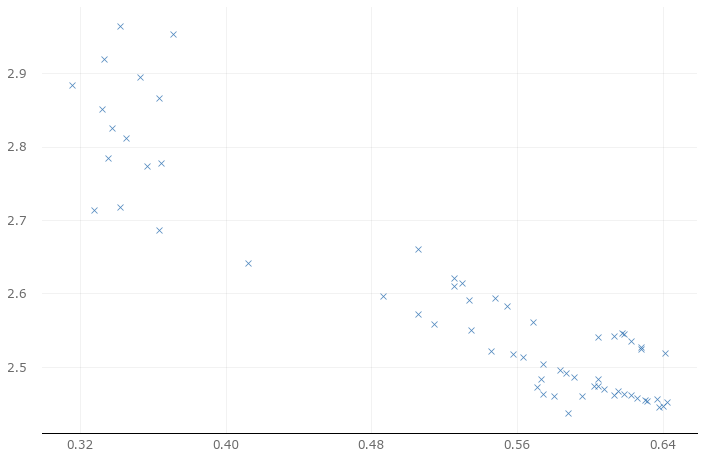

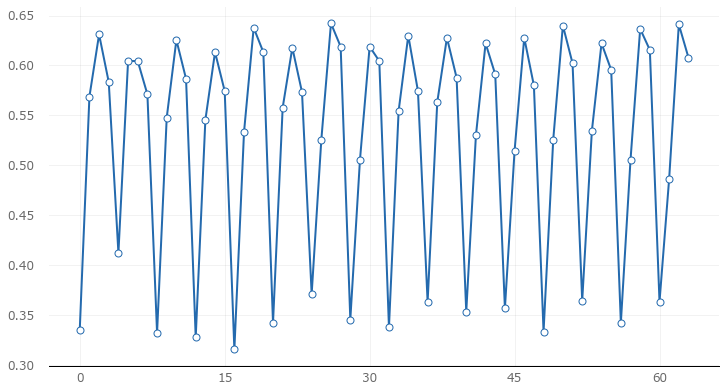

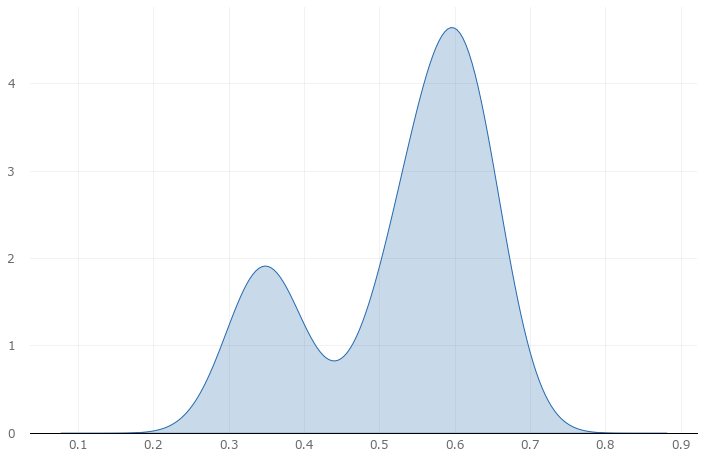

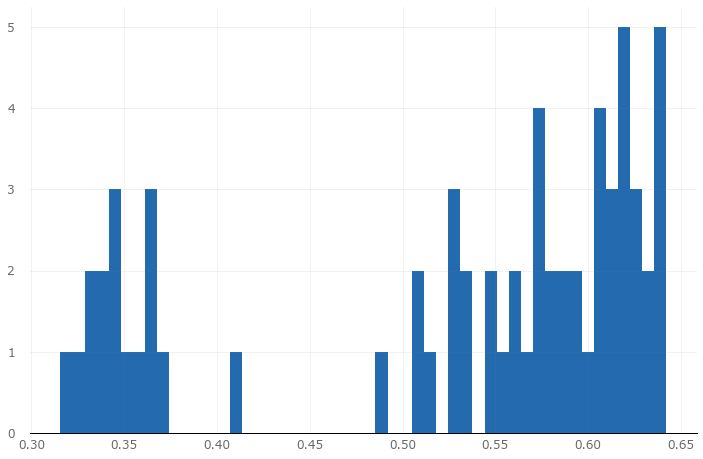

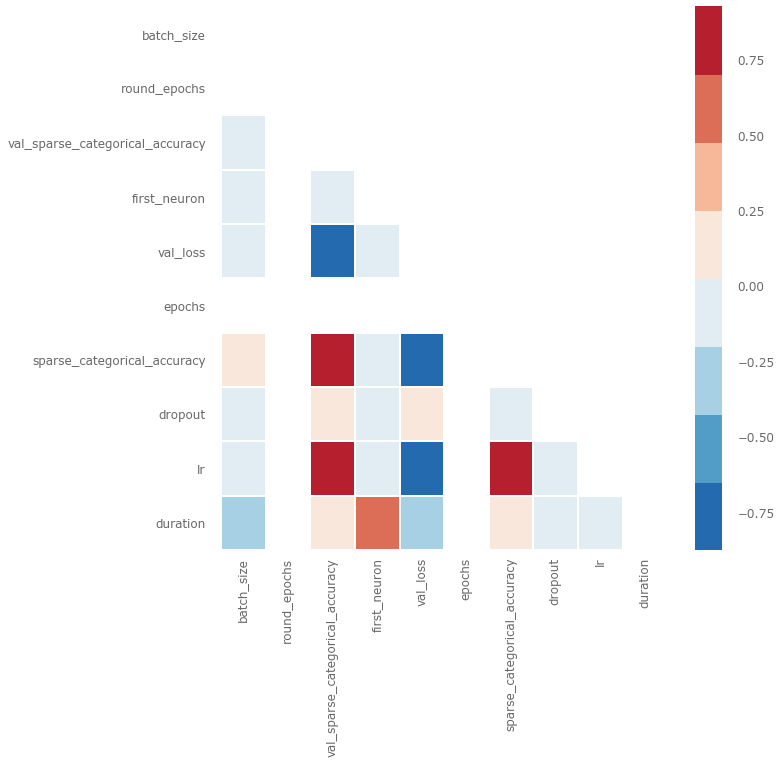

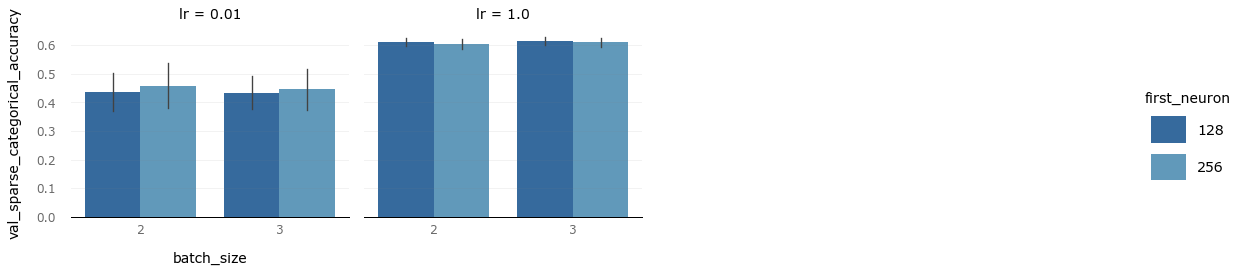

In [91]:
# a regression plot for two dimensions 
analyze_object.plot_regs('val_sparse_categorical_accuracy', 'val_loss')

# line plot
analyze_object.plot_line('val_sparse_categorical_accuracy')

# up to two dimensional kernel density estimator
analyze_object.plot_kde('val_sparse_categorical_accuracy')

# a simple histogram
analyze_object.plot_hist('val_sparse_categorical_accuracy', bins=50)

# heatmap correlation
analyze_object.plot_corr('val_loss', ['acc', 'loss', 'val_loss'])

# a four dimensional bar grid
analyze_object.plot_bars('batch_size', 'val_sparse_categorical_accuracy', 'first_neuron', 'lr')

In [93]:
talos.Deploy(scan_object=scan_object, model_name='cuisine_deploy', metric='val_sparse_categorical_accuracy')
iris = talos.Restore('cuisine_deploy.zip')

FileExistsError: [WinError 183] 當檔案已存在時，無法建立該檔案。: 'cuisine_deploy'

In [ ]:
# make predictions with the model
iris.model.predict(test_x)
# get the meta-data for the experiment
iris.details

In [ ]:
# get the hyperparameter space boundary
iris.params

In [ ]:
# the results dataframe
iris.results